# FlyWire Connectome Query

By Charles Xu @ Caltech

We will query the FlyWire connectome using CAVE to obtain connectivity matrices by select single cells or cell types in relavent neuropils.

## Setup

At this point starting up the client is unnecessary because tables will be downloaded and processed locally instead of being queried from the remote. Caveclient does not seem to support query by cell ID.

In [1]:
import caveclient
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from scipy.io import savemat
import pickle
import sympy as sp
from scipy.linalg import schur
import os

### User defined variables

In [116]:
# User options
savedata = True                                            # Set to True to save data to files
# datapath = '/home/charlesxu/local/data/flyIgnition/EBTripartite/' # Ubuntu
# datapath = '/Users/alveus/Documents/WorkingDirectory/Data/KIBM/flyIgnition/remodel/' # MBP
datapath = '/Users/charlesxu/local/data/flyIgnition/ignition/20250625' # MMN

plot = True                                                # Set to True to plot
showplots = True                                           # Set to True to show plots
saveplots = True                                           # Set to True to save plots to files
# plotpath = '/home/charlesxu/local/data/flyIgnition/EBTripartite/plots/' # Ubuntu
# plotpath = '/Users/alveus/Documents/WorkingDirectory/Data/KIBM/flyIgnition/remodel/plots/' # MBP
plotpath = '/Users/charlesxu/local/data/flyIgnition/ignition/20250625/plots' # MMN

#### Token

In [23]:
# Run this cell to get a new token

# client = caveclient.CAVEclient()
# client.auth.setup_token(make_new=True)

In [24]:
# Run this cell to save the token to the client

# my_token = "2713d56df2741d2ae40fc372511f3188"
# client.auth.save_token(token=my_token, overwrite=True)

In [25]:
# my_token = "2713d56df2741d2ae40fc372511f3188"   # This token is generated by Charles Xu

In [26]:
# datastack_name = "flywire_fafb_public"
# client = caveclient.CAVEclient(datastack_name, auth_token=my_token)

## Query

In [27]:
# client.materialize.get_versions()

In [28]:
# client.version = 630

In [29]:
# client.materialize.get_tables()

In [30]:
## Query proofread neurons

# proofread_neurons_df = client.materialize.query_table("proofread_neurons")
# proofread_neurons_df

In [31]:
## Query synapses

# neuropil_df = client.materialize.query_table("fly_synapses_neuropil_v6")
# neuropil_df

### Query by NPOI

In [8]:
## Query neurons forming synapses in select neuropils
# Download the table at https://codex.flywire.ai/api/download?data_product=connections&data_version=783

path_connections = os.path.join(datapath, "connections.csv")
connections_df = pd.read_csv(path_connections)
connections_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [66]:
## Get a list of presynaptic neurons for each neuropil
# Query by non-zero output partners

# List of neuropils of interest
roi = ["EB", "PB", "NO", "FB",
        "LAL_R", "BU_R", "CRE_R", "SIP_R", "SLP_R", "SMP_R",
        "IB_R", "SPS_R", "IPS_R", "AOTU_R", "PVLP_R", "WED_R", "SAD", "LH_R", "MB_CA_R", "MB_ML_R", "MB_PED_R", "MB_VL_R", "AL_R"] # fix MB_R

# Get lists of neurons with non-zero output partners in each neuropil
neurons_roi = {}
for neuropil in roi:
    neurons_roi[neuropil] = connections_df[connections_df["neuropil"] == neuropil]["pre_root_id"].values.tolist()

# Print the number of neurons in each neuropil
for neuropil, neurons in neurons_roi.items():
    print(f"{neuropil}: {len(set(neurons))} neurons")

# Unique list of neurons in all neuropils of interest
noi_set = set()
for neuropil in roi:
    noi_set.update(neurons_roi[neuropil])
noi_list = list(noi_set)

if savedata:
    try:
        with open(datapath + 'noi_list.pkl', 'wb') as f:
            pickle.dump(noi_list, f)
    except:
        print("Error saving noi_list.pkl")

print(f"Aggregated number of unique neurons in all neuropils of interest: {len(noi_list)}")

EB: 750 neurons
PB: 610 neurons
NO: 744 neurons
FB: 2417 neurons
LAL_R: 1799 neurons
BU_R: 207 neurons
CRE_R: 4337 neurons
SIP_R: 3167 neurons
SLP_R: 4857 neurons
SMP_R: 5341 neurons
IB_R: 2060 neurons
SPS_R: 4408 neurons
IPS_R: 2976 neurons
AOTU_R: 1277 neurons
PVLP_R: 4086 neurons
WED_R: 2251 neurons
SAD: 4813 neurons
LH_R: 2945 neurons
MB_CA_R: 2924 neurons
MB_ML_R: 3438 neurons
MB_PED_R: 3418 neurons
MB_VL_R: 2116 neurons
AL_R: 2961 neurons
Aggregated number of unique neurons in all neuropils of interest: 28205


#### Query for synapses

For each neuron of interest, we will query for its synapses formed in the neuropil of interest and assign a binary weight value (`1` or `-1`) based on their neurotransmitter type.

In [67]:
# ## Query neurons forming synapses in select neuropils
# # Download the table at https://codex.flywire.ai/api/download?data_product=connections&data_version=783

# path_connections = datapath + 'connections.csv' # Path to the connections table
# connections_df = pd.read_csv(path_connections)
# connections_df

In [68]:
print(f"Aggregated number of unique neurons in all neuropils of interest: {len(noi_list)}")
print(f"The neurotransmitters involved are: {connections_df['nt_type'].unique()}")

Aggregated number of unique neurons in all neuropils of interest: 28205
The neurotransmitters involved are: ['GABA' 'ACH' 'GLUT' 'DA' 'SER' 'OCT']


In [ ]:
# Manually assign weights to neurotransmitters
# These weights are used to scale the number of synapses between neurons
nt_weights = {
    'GABA': -1, # References?
    'ACH': 1,
    'GLU': -1,
    'DA': 1,
    'SER': 1,
    'OCT': 1
}

In [70]:
# Filter connections to only include neurons in the list
filtered_connections_df = connections_df[
    (connections_df["pre_root_id"].isin(noi_list)) &
    (connections_df["post_root_id"].isin(noi_list)) &
    (connections_df["neuropil"].isin(roi))
]

del connections_df

filtered_connections_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
1,720575940605876866,720575940606514878,LAL_R,15,GABA
3,720575940633587552,720575940626452879,SMP_R,15,ACH
7,720575940613583001,720575940623353013,MB_ML_R,9,GABA
11,720575940634042012,720575940623989577,SMP_R,9,GLUT
12,720575940630005147,720575940624606758,SLP_R,4,ACH
...,...,...,...,...,...
3869853,720575940616097130,720575940605607392,IPS_R,1,GLUT
3869866,720575940612446866,720575940606567125,SAD,3,ACH
3869870,720575940617453083,720575940628118159,CRE_R,2,ACH
3869872,720575940639209461,720575940622433140,MB_ML_R,1,GABA


### Query by cell type

In [77]:
## Query neurons of select cell types
# Download the table at https://codex.flywire.ai/api/download?data_product=classification&data_version=783

path_classification = os.path.join(datapath, "classification.csv")
classification_df = pd.read_csv(path_classification)
classification_df

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
0,720575940640144768,intrinsic,optic,NaN,L1-5,L1,NaN,NaN,right,NaN
1,720575940630759755,intrinsic,central,NaN,NaN,CB1092,NaN,LB3,left,NaN
2,720575940637932009,intrinsic,central,Kenyon_Cell,NaN,NaN,KCg-m,MBp3,left,NaN
3,720575940606131116,intrinsic,optic,NaN,NaN,Tlp4,NaN,NaN,left,NaN
4,720575940633723091,intrinsic,optic,NaN,NaN,Tm4,NaN,NaN,left,NaN
...,...,...,...,...,...,...,...,...,...,...
139250,720575940632239661,afferent,sensory,olfactory,NaN,ORN_VM6l,ORN_VC5,NaN,right,AN
139251,720575940624423312,intrinsic,optic,NaN,NaN,TmY5a,NaN,NaN,right,NaN
139252,720575940625090916,intrinsic,optic,NaN,NaN,NaN,NaN,NaN,left,NaN
139253,720575940631596103,intrinsic,optic,NaN,NaN,T2a,NaN,NaN,left,NaN


In [ ]:
# hemibrain_types = classification_df['hemibrain_type'].unique()

# # Expand comma-separated values into multiple columns
# hemibrain_types_expanded = pd.DataFrame(
#     [str(x).split(',') if pd.notnull(x) else [np.nan] for x in hemibrain_types]
# )

# hemibrain_types_first = hemibrain_types_expanded.iloc[:, 0].values

# hemibrain_types.shape, hemibrain_types_expanded.shape, hemibrain_types_first.shape

((3552,), (3552, 9), (3552,))

In [ ]:
# hemibrain_types_first = hemibrain_types_first[~pd.isnull(hemibrain_types_first)]
# hemibrain_types_first.shape

(3551,)

In [66]:
ctoi = ["ER2", "ER3a", "ER3d", "ER3m", "ER3p", "ER3w", "ER4d", "ER4m", "EPG"]

In [67]:
# List of cell types of interest
# ctoi = ["TuBu09", "ER2", "ER3w", "EPG", "EL"]
# ctoi = hemibrain_types_first

# List of all cell types (in hemibrain_type)
col_hemibrain_type = classification_df['hemibrain_type'].str.split(',')
all_hemibrain_type = col_hemibrain_type.explode().unique().astype(str).tolist()

# Verify if the cell types of interest are in the list
for cell_type in ctoi:
    print(f"Matching type found for {cell_type}: {cell_type in all_hemibrain_type}")

# Get the root_id of neurons of the cell types of interest
neurons_ctoi = {}
for cell_type in ctoi:
    neurons_ctoi[cell_type] = classification_df[col_hemibrain_type.apply(lambda x: cell_type in x if isinstance(x, list) else False)]["root_id"].values.tolist()

# Print the number of neurons in each cell type
for cell_type, neurons in neurons_ctoi.items():
    print(f"{cell_type}: {len(neurons)} neurons")

# Unique list of neurons in all cell types of interest
noi_set = set()
for cell_type in ctoi:
    noi_set.update(neurons_ctoi[cell_type])
noi_list = list(noi_set)

# Generate a list of cell types corresponding to each root_id in noi_list
ctoi_list = []
for root_id in noi_list:
    # hemibrain_type = classification_df[classification_df["root_id"] == root_id]["hemibrain_type"].values
    # cell_type = classification_df[classification_df["root_id"] == root_id]["cell_type"].values
    is_in_hemibrain = [classification_df[classification_df["root_id"] == root_id]["hemibrain_type"].str.contains(cell_type, na=False).any() for cell_type in ctoi]
    is_in_cell_type = [classification_df[classification_df["root_id"] == root_id]["cell_type"].str.contains(cell_type, na=False).any() for cell_type in ctoi]
    if any(is_in_hemibrain):
        ctoi_list.append(ctoi[is_in_hemibrain.index(True)])
    elif any(is_in_cell_type):
        ctoi_list.append(ctoi[is_in_cell_type.index(True)])
    else:
        ctoi_list.append(None)
    # if len(hemibrain_type) > 0:
    #     ctoi_list.append(hemibrain_type[0])
    # elif len(cell_type) > 0:
    #     ctoi_list.append(cell_type[0])
    # else:
    #     ctoi_list.append(None)

print(f"Generated ctoi_list with {len(ctoi_list)} entries")

Matching type found for ER2: True
Matching type found for ER3a: True
Matching type found for ER3d: True
Matching type found for ER3m: True
Matching type found for ER3p: True
Matching type found for ER3w: True
Matching type found for ER4d: True
Matching type found for ER4m: True
Matching type found for EPG: True
ER2: 41 neurons
ER3a: 37 neurons
ER3d: 51 neurons
ER3m: 16 neurons
ER3p: 17 neurons
ER3w: 25 neurons
ER4d: 26 neurons
ER4m: 11 neurons
EPG: 47 neurons
Generated ctoi_list with 271 entries


In [70]:
## Query neurons forming synapses in select neuropils
# Download the table at https://codex.flywire.ai/api/download?data_product=connections&data_version=783

path_connections = os.path.join(datapath, "connections.csv")
connections_df = pd.read_csv(path_connections)
connections_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [71]:
# Extract rows where 'pre_root_id' or 'post_root_id' matches any entry in noi_list
matched_connections_df = connections_df[
    (connections_df['pre_root_id'].isin(noi_list)) | (connections_df['post_root_id'].isin(noi_list))
]

matched_connections_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
20,720575940622252493,720575940639214655,EB,26,GABA
25,720575940625516830,720575940624373837,EB,17,GABA
27,720575940622252493,720575940630658807,EB,15,GABA
35,720575940629244166,720575940639214655,EB,47,GABA
40,720575940631154743,720575940611216099,GA_L,9,GABA
...,...,...,...,...,...
3866693,720575940637699747,720575940611216099,EB,5,GABA
3867421,720575940622342576,720575940628802041,CRE_L,1,GABA
3868802,720575940616569601,720575940625508500,PB,5,ACH
3869372,720575940623466632,720575940629213639,CRE_L,1,GABA


In [94]:
# Get all unique entries in pre_root_id and post_root_id, combined
noi_partners_list = pd.unique(
    matched_connections_df[['pre_root_id', 'post_root_id']].values.ravel()
)
print(f"Number of unique neuron IDs: {len(noi_partners_list)}")
noi_partners_list[:10]

Number of unique neuron IDs: 862


array([720575940622252493, 720575940639214655, 720575940625516830,
       720575940624373837, 720575940630658807, 720575940629244166,
       720575940631154743, 720575940611216099, 720575940625464328,
       720575940619767744])

In [110]:
# Generate a list of cell types corresponding to each root_id in noi_partners_list
ctoi_partners_list = []
no_ctoi = []
for i, root_id in enumerate(noi_partners_list):
    row = classification_df[classification_df["root_id"] == root_id]
    if not row.empty:
        # Try to match with ctoi using hemibrain_type or cell_type columns
        hemibrain_types = str(row.iloc[0]["hemibrain_type"]).split(",") if pd.notnull(row.iloc[0]["hemibrain_type"]) else []
        cell_types = str(row.iloc[0]["cell_type"]).split(",") if pd.notnull(row.iloc[0]["cell_type"]) else []
        if hemibrain_types:
            ctoi_partners_list.append(hemibrain_types[0])
        elif cell_types:
            ctoi_partners_list.append(cell_types[0])
        else:
            print(f"Neuron {root_id} not assigned to any cell type.")
            ctoi_partners_list.append(None)
            no_ctoi.append(i)
    else:
        print(f"Neuron {root_id} not found in classification_df.")
        ctoi_partners_list.append(None)
        no_ctoi.append(i)

print(f"Generated ctoi_partners_list with {len(ctoi_partners_list)} entries")
ctoi_partners_list[:10]

Neuron 720575940630199759 not assigned to any cell type.
Neuron 720575940619574181 not assigned to any cell type.
Neuron 720575940619489088 not assigned to any cell type.
Neuron 720575940623482894 not assigned to any cell type.
Neuron 720575940624156391 not assigned to any cell type.
Neuron 720575940616040148 not assigned to any cell type.
Neuron 720575940615673949 not assigned to any cell type.
Neuron 720575940630021115 not assigned to any cell type.
Neuron 720575940623441629 not assigned to any cell type.
Generated ctoi_partners_list with 862 entries


['ER3m', 'ER3a', 'ER4d', 'ER4d', 'ER3m', 'ER3d', 'ER6', 'EPG', 'ER3d', 'ER3d']

In [112]:
# Remove entries specified by no_ctoi from noi_partners_list and ctoi_partners_list
noi_partners_list_filtered = np.delete(noi_partners_list, no_ctoi)
ctoi_partners_list_filtered = [ctoi_partners_list[i] for i in range(len(ctoi_partners_list)) if i not in no_ctoi]

print(f"Filtered noi_partners_list length: {len(noi_partners_list_filtered)}")
print(f"Filtered ctoi_partners_list length: {len(ctoi_partners_list_filtered)}")

Filtered noi_partners_list length: 853
Filtered ctoi_partners_list length: 853


In [131]:
noi_list = noi_partners_list_filtered.tolist()
ctoi_list = ctoi_partners_list_filtered

len(noi_list), len(ctoi_list)

(853, 853)

In [132]:
import csv

if savedata:
    try:
        with open(os.path.join(datapath, 'noi_list.csv'), 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Neuron ID'])  # Add a header
            for neuron_id in noi_list:
                writer.writerow([neuron_id])
    except Exception as e:
        print(f"Error saving noi_list.csv: {e}")
        
    try:
        with open(os.path.join(datapath, 'ctoi_list.csv'), 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Cell Type'])  # Add a header
            for cell_type in ctoi_list:
                writer.writerow([cell_type])
    except Exception as e:
        print(f"Error saving ctoi_list.csv: {e}")

#### Query for synapses

For each neuron of interest, we will query for its synapses formed in the neuropil of interest and assign a binary weight value (`1` or `-1`) based on their neurotransmitter type.

In [119]:
## Query neurons forming synapses in select neuropils
# Download the table at https://codex.flywire.ai/api/download?data_product=connections&data_version=783

path_connections = os.path.join(datapath, "connections.csv")
connections_df = pd.read_csv(path_connections)
connections_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
0,720575940629970489,720575940631267655,AVLP_R,7,GABA
1,720575940605876866,720575940606514878,LAL_R,15,GABA
2,720575940627737365,720575940628914436,AL_L,32,ACH
3,720575940633587552,720575940626452879,SMP_R,15,ACH
4,720575940616871878,720575940621203973,AVLP_L,13,GABA
...,...,...,...,...,...
3869873,720575940621773517,720575940611139733,PVLP_R,1,ACH
3869874,720575940622734576,720575940609171395,ICL_L,2,ACH
3869875,720575940638466367,720575940627036426,LO_L,5,ACH
3869876,720575940629789660,720575940631553603,GOR_R,3,ACH


In [120]:
print(f"Aggregated number of unique neurons in all neuropils of interest: {len(noi_list)}")
print(f"The neurotransmitters involved are: {connections_df['nt_type'].unique()}")

Aggregated number of unique neurons in all neuropils of interest: 853
The neurotransmitters involved are: ['GABA' 'ACH' 'GLUT' 'DA' 'SER' 'OCT']


In [121]:
# Manually assign weights to neurotransmitters
# These weights are used to scale the number of synapses between neurons
nt_weights = {
    'GABA': -1, # References?
    'ACH': 1,
    'GLU': -1,
    'DA': 1,
    'SER': 1,
    'OCT': 1
}

In [122]:
# Filter connections to only include neurons in the list
filtered_connections_df = connections_df[
    (connections_df["pre_root_id"].isin(noi_list)) &
    (connections_df["post_root_id"].isin(noi_list))
]

del connections_df

filtered_connections_df

,pre_root_id,post_root_id,neuropil,syn_count,nt_type
20,720575940622252493,720575940639214655,EB,26,GABA
25,720575940625516830,720575940624373837,EB,17,GABA
27,720575940622252493,720575940630658807,EB,15,GABA
35,720575940629244166,720575940639214655,EB,47,GABA
40,720575940631154743,720575940611216099,GA_L,9,GABA
...,...,...,...,...,...
3868862,720575940623317321,720575940609716430,FB,1,GABA
3869118,720575940625021796,720575940620571953,FB,1,ACH
3869126,720575940621268830,720575940616764731,FB,3,GLUT
3869372,720575940623466632,720575940629213639,CRE_L,1,GABA


In [123]:
print(f"The neurotransmitters involved are: {filtered_connections_df['nt_type'].unique()}")

The neurotransmitters involved are: ['GABA' 'GLUT' 'ACH' 'DA' 'SER' 'OCT']


## Connectivity matrix

### Single neuron connectivity

In [133]:
## Generate a connectivity matrix

# Calculate the connectivity between each pair of neurons
filtered_connections_df.loc[:, 'connectivity'] = filtered_connections_df['syn_count'] * filtered_connections_df['nt_type'].map(nt_weights)

# Group the connections by neuron pair
grouped_connections_df = filtered_connections_df.groupby(['pre_root_id', 'post_root_id']).agg({'connectivity': 'sum'}).reset_index()

# Connectivity matrix
n_neurons = len(noi_list)
connectivity_matrix = np.zeros((n_neurons, n_neurons))
for _, row in grouped_connections_df.iterrows():
    pre_id = row['pre_root_id']
    post_id = row['post_root_id']
    conn = row['connectivity']
    pre_idx = noi_list.index(pre_id)
    post_idx = noi_list.index(post_id)
    connectivity_matrix[pre_idx, post_idx] = conn

del grouped_connections_df

if savedata:
    connectivity_df = pd.DataFrame(connectivity_matrix, index=noi_list, columns=noi_list)
    connectivity_df.to_csv(os.path.join(datapath, 'connectivity_matrix.csv'))

connectivity_matrix

array([[  0., -26.,   0., ...,   0.,   0.,   0.],
       [-12.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]], shape=(853, 853))

In [33]:
# Function to detect the sign of the first non-zero value in a row
def detect_first_nonzero_sign(row):
    for value in row:
        if value != 0:
            return np.sign(value)
    return 0  # Return 0 if the row is all zeros

# Function to check if the row contains a value of the opposite sign
def contains_opposite_sign(row, first_sign):
    for value in row:
        if value != 0 and np.sign(value) != first_sign:
            return True
    return False

# Initialize an array to store the logical results
logical_results = np.zeros(n_neurons, dtype=bool)

# Iterate through each row in the connectivity matrix
for i, row in enumerate(connectivity_matrix):
    first_sign = detect_first_nonzero_sign(row)
    if first_sign != 0:
        has_opposite_sign = contains_opposite_sign(row, first_sign)
        logical_results[i] = has_opposite_sign
    else:
        logical_results[i] = False

logical_results

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [15]:
connectivity_matrix[3, :]

array([ -6.,  -5.,   0.,   0., -14.,   0.,  -6.,   0.,   0., -11.,   0.,
        -5., -19.,   0.,   0.,   0.,   0.,   0.,   0.,  -6.,   0.,  -6.,
         0.,   0., -17.,  -7.,  -5.,  -7.,  -5.,   0.,   0.,  -8., -11.,
       -11.,   0.,   0., -22.,   0.,  -5.,  -9.,  -9.,  -6.,   0., -21.,
       -22.,   0., -10.,  -7.,  -7.,   0.,   0.,   0.,  -8., -16.,  -7.,
         0.,   0.,   0.,   0.,   0.,  -5.,  -8., -10.,   0.,  -6.,   0.,
         0., -16.,   0.,   0.,   0.,  -5.,  -5.,   0., -14.,  -6.,   0.,
         0.,  -9., -11.,   0.,   0.,   0.,   0.,  -5.,  -6.,  -7.,   0.,
         0., -19., -18., -10.,   0.,   0.,   0.,   0.,   0., -18.,   0.,
       -20., -22.,  -9.,   0.,  -9.,  -8., -16.,  -5., -16.,   0.,   0.,
         0.,  -9.,   0.,   0.,   0.,   0.,  -7.,   0.,   0.,  -9.,  -5.,
         0.,   0.,   0.,   0.,  -8.,  -9.,  -8.,  -5.,  -8.,   0.,   0.,
         0.,  -5., -15.,   0.,  -9.,   0., -11., -10.,   0.,   0.,   0.,
       -15.,   0.,   0.,   0.,  -8., -13.,   0.,  -

In [16]:
# Create an empty matrix to store the nt_type
nt_type_matrix = np.empty((n_neurons, n_neurons), dtype=object)

# Fill the matrix with the corresponding nt_type
for _, row in filtered_connections_df.iterrows():
    pre_id = row['pre_root_id']
    post_id = row['post_root_id']
    nt_type = row['nt_type']
    pre_idx = noi_list.index(pre_id)
    post_idx = noi_list.index(post_id)
    nt_type_matrix[pre_idx, post_idx] = nt_type

if savedata:
    nt_type_df = pd.DataFrame(nt_type_matrix, index=ctoi_list, columns=ctoi_list)
    nt_type_df.to_csv(datapath + 'nt_type_matrix.csv')

nt_type_matrix

array([[None, None, None, ..., 'GABA', 'GABA', None],
       ['GABA', None, None, ..., 'GABA', 'GABA', 'GABA'],
       [None, None, None, ..., None, None, None],
       ...,
       [None, 'ACH', None, ..., None, None, None],
       [None, 'GABA', None, ..., 'GABA', None, 'GABA'],
       [None, 'GABA', None, ..., 'GABA', 'GABA', None]], dtype=object)

In [17]:
nt_type_matrix[3, :]

array(['GABA', 'GABA', None, None, 'GABA', None, 'GABA', None, None,
       'GABA', None, 'GABA', 'GABA', None, None, None, None, None, None,
       'GABA', None, 'GABA', None, None, 'GABA', 'GABA', 'GABA', 'GABA',
       'GABA', None, None, 'GABA', 'GABA', 'GABA', None, None, 'GABA',
       None, 'GABA', 'GABA', 'GABA', 'GABA', None, 'GABA', 'GABA', None,
       'GABA', 'GABA', 'GABA', None, None, None, 'GABA', 'GABA', 'GABA',
       None, None, None, None, None, 'GABA', 'GABA', 'GABA', None, 'GABA',
       None, None, 'GABA', None, None, None, 'GABA', 'GABA', None, 'GABA',
       'GABA', None, None, 'GABA', 'GABA', None, None, None, None, 'GABA',
       'GABA', 'GABA', None, None, 'GABA', 'GABA', 'GABA', None, None,
       None, None, None, 'GABA', None, 'GABA', 'GABA', 'GABA', None,
       'GABA', 'GABA', 'GABA', 'GABA', 'GABA', None, None, None, 'GABA',
       None, None, None, None, 'GABA', None, None, 'GABA', 'GABA', None,
       None, None, None, 'GABA', 'GABA', 'GABA', 'GABA', 

In [18]:
## Save the connectivity matrix

# Save to a numpy file
# Read with: connectivity_matrix = np.load('connectivity_matrix.npy')
# if savedata:
#     np.save(datapath + 'connectivity_matrix.npy', connectivity_matrix)

# Save to a CSV file (requires a large memory)
# Read with: connectivity_df = pd.read_csv('connectivity_matrix.csv', index_col=0)
# if savedata:
#     connectivity_df = pd.DataFrame(connectivity_matrix, index=noi_list, columns=noi_list)
#     connectivity_df.to_csv(datapath + 'connectivity_matrix.csv')

# Save to a MATLAB file
# Read with: connectivity_matrix = scipy.io.loadmat('connectivity_matrix.mat')['connectivity_matrix']
# if savedata:
#     try:
#         savemat(datapath + 'connectivity_matrix.mat', {'connectivity_matrix': connectivity_matrix})
#     except:
#         print("Error saving connectivity_matrix.mat")

# Save to a pickle file
# Read with: with open('connectivity_matrix.pkl', 'rb') as f: connectivity_matrix = pickle.load(f)
# if savedata:
#     connectivity_matrix_list = connectivity_matrix.tolist()
#     with open(datapath + 'connectivity_matrix.pkl', 'wb') as f:
#         pickle.dump(connectivity_matrix_list, f)

In [19]:
# Load the connectivity matrix
# connectivity_matrix = np.load(datapath + 'connectivity_matrix.npy')

### Visualisation

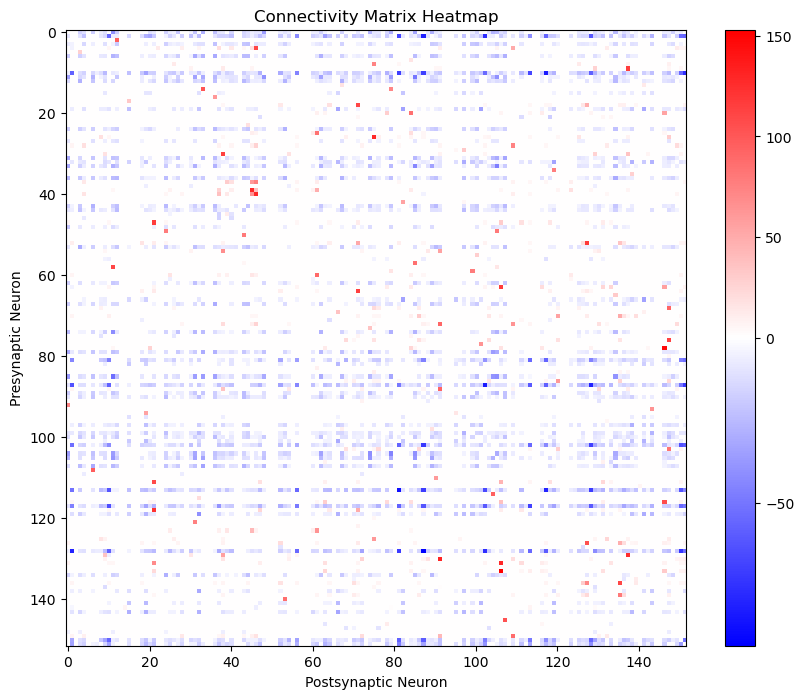

<Figure size 640x480 with 0 Axes>

In [22]:
## Visualize the connectivity matrix

# Plot the connectivity matrix as a heatmap
if plot:
    plt.figure(figsize=(10, 8))
    norm = colors.TwoSlopeNorm(vcenter=0)
    plt.imshow(connectivity_matrix, cmap='bwr', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title('Connectivity Matrix Heatmap')
    plt.xlabel('Postsynaptic Neuron')
    plt.ylabel('Presynaptic Neuron')
    if showplots:
        plt.show()
    else:
        plt.close()
    if saveplots:
        plt.savefig(plotpath + 'connectivity_matrix_heatmap.png')

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


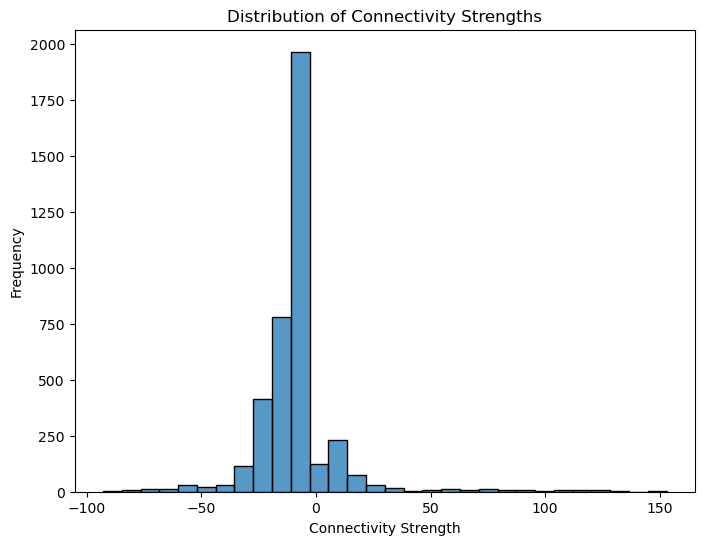

<Figure size 640x480 with 0 Axes>

In [23]:
# Plot the distribution of connectivity strengths
if plot:
    connectivity_values = connectivity_matrix.flatten()
    nz_connectivity_values = connectivity_values[connectivity_values != 0]
    plt.figure(figsize=(8, 6))
    sns.histplot(nz_connectivity_values, bins=30)
    plt.title('Distribution of Connectivity Strengths')
    plt.xlabel('Connectivity Strength')
    plt.ylabel('Frequency')
    if showplots:
        plt.show()
    else:
        plt.close()
    if saveplots:
        plt.savefig(plotpath + 'connectivity_strengths_distribution.png')

### Neuropil connectivity

## Cell type

In [22]:
## Query cell types for each neuron
# Download the table at https://codex.flywire.ai/api/download?data_product=classification&data_version=783

path_celltype = datapath + 'classification.csv' # Path to the connections table
celltype_df = pd.read_csv(path_celltype)
celltype_df

,root_id,flow,super_class,class,sub_class,cell_type,hemibrain_type,hemilineage,side,nerve
0,720575940640144768,intrinsic,optic,NaN,L1-5,L1,NaN,NaN,right,NaN
1,720575940630759755,intrinsic,central,NaN,NaN,CB1092,NaN,LB3,left,NaN
2,720575940637932009,intrinsic,central,Kenyon_Cell,NaN,NaN,KCg-m,MBp3,left,NaN
3,720575940606131116,intrinsic,optic,NaN,NaN,Tlp4,NaN,NaN,left,NaN
4,720575940633723091,intrinsic,optic,NaN,NaN,Tm4,NaN,NaN,left,NaN
...,...,...,...,...,...,...,...,...,...,...
139250,720575940632239661,afferent,sensory,olfactory,NaN,ORN_VM6l,ORN_VC5,NaN,right,AN
139251,720575940624423312,intrinsic,optic,NaN,NaN,TmY5a,NaN,NaN,right,NaN
139252,720575940625090916,intrinsic,optic,NaN,NaN,NaN,NaN,NaN,left,NaN
139253,720575940631596103,intrinsic,optic,NaN,NaN,T2a,NaN,NaN,left,NaN


In [23]:
# Filter for neurons of interest
celltype_filtered_df = celltype_df[celltype_df['root_id'].isin(noi_list)]
celltype_filtered_df = celltype_filtered_df.set_index('root_id').reindex(noi_list).reset_index()
celltype_noi_df = celltype_filtered_df[['root_id', 'super_class', 'class', 'sub_class', 'cell_type']]
del celltype_df, celltype_filtered_df
celltype_noi_df

,root_id,super_class,class,sub_class,cell_type
0,720575940628185088,central,NaN,NaN,CB2954
1,720575940631199744,visual_projection,NaN,NaN,NaN
2,720575940624384007,sensory,olfactory,NaN,NaN
3,720575940623990797,central,NaN,NaN,CB3532
4,720575940643127319,visual_projection,NaN,NaN,LC10d
...,...,...,...,...,...
28200,720575940625563623,central,NaN,NaN,NaN
28201,720575940622811116,central,CX,columnar,NaN
28202,720575940611145714,central,NaN,NaN,NaN
28203,720575940651646966,central,NaN,NaN,NaN


In [27]:
# Save the cell type data for neurons of interest
if savedata:
    try:
        celltype_noi_df.to_csv(datapath + 'celltype_noi.csv', index=False)
    except:
        print("Error saving celltype_noi.csv")

## Matrix decompositions

### Jordan normal form

In [137]:
# # Convert the NumPy array to a SymPy Matrix
# sp_connectivity_matrix = sp.Matrix(connectivity_matrix)

# # Compute the Jordan Normal Form
# jordan_form, P = sp_connectivity_matrix.jordan_form()

# # Print the Jordan form and the transformation matrix
# print("Jordan Normal Form:")
# sp.pprint(jordan_form)

# print("\nTransformation Matrix P:")
# sp.pprint(P)

In [41]:
# Compute the eigenvalues and eigenvectors numerically using numpy
eigenvalues, eigenvectors = np.linalg.eig(connectivity_matrix)

# Convert the eigenvalues and eigenvectors back to SymPy
sp_eigenvalues = sp.Matrix(np.diag(eigenvalues))
sp_eigenvectors = sp.Matrix(eigenvectors)

# Construct the Jordan form and the transformation matrix
jordan_form = sp_eigenvalues
P = sp_eigenvectors

# Print the Jordan form and the transformation matrix
print("Jordan Normal Form:")
sp.pprint(jordan_form)

print("\nTransformation Matrix P:")
sp.pprint(P)

Jordan Normal Form:
⎡0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
⎢                                                                             
⎢0  0  0  0  0  0  0  0  0  0  0

### Schur decomposition

In [42]:
# Compute the Schur decomposition
T, Q = schur(connectivity_matrix)

# Print the results
print("Schur Form (T):")
print(T)

print("\nUnitary Matrix (Q):")
print(Q)

Schur Form (T):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Unitary Matrix (Q):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


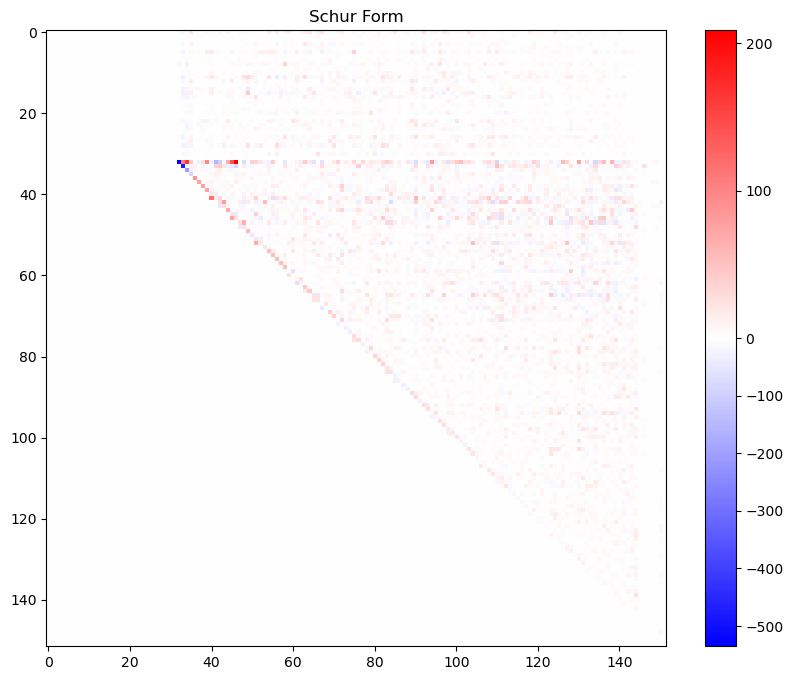

<Figure size 640x480 with 0 Axes>

In [43]:
# Plot the Schur form
if plot:
    plt.figure(figsize=(10, 8))
    norm = colors.TwoSlopeNorm(vcenter=0)
    plt.imshow(T, cmap='bwr', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title('Schur Form')
    if showplots:
        plt.show()
    else:
        plt.close()
    if saveplots:
        plt.savefig(plotpath + 'schur_form.png')

### SVD

In [44]:
# Compute the SVD
U, S, Vh = np.linalg.svd(connectivity_matrix)

# Print the results
print("Unitary Matrix U:")
print(U)

print("\nSingular Values (Diagonal of Sigma):")
print(S)

print("\nUnitary Matrix Vh (V conjugate transpose):")
print(Vh)

Unitary Matrix U:
[[ 9.53779596e-02  1.98325887e-01 -2.43762789e-02 ...  6.74069510e-15
  -9.91178789e-15  1.50408346e-15]
 [ 2.82189774e-01 -1.55659892e-01  1.70722015e-04 ... -3.37151084e-16
   5.21741773e-16 -9.26252127e-17]
 [-8.56814640e-03 -3.11679819e-02 -5.26970906e-03 ... -1.93973344e-15
   3.06772136e-15 -4.33403700e-16]
 ...
 [-2.13259649e-02 -2.28338482e-03 -5.76097077e-02 ...  9.09579688e-16
  -1.15139288e-15  1.86892517e-16]
 [ 2.38828386e-01 -1.09600013e-01  3.21390297e-02 ...  1.27119898e-15
  -1.93019220e-15  2.93686040e-16]
 [ 1.96404742e-01 -7.99316322e-02 -7.11717508e-03 ...  1.93885290e-15
  -2.75522654e-15  3.96671107e-16]]

Singular Values (Diagonal of Sigma):
[7.76622598e+02 4.77653420e+02 2.92977260e+02 2.60893755e+02
 2.46386079e+02 2.29336619e+02 2.13205044e+02 2.09418980e+02
 2.05717161e+02 1.94159887e+02 1.63084992e+02 1.57373313e+02
 1.46153364e+02 1.39854509e+02 1.30927174e+02 1.26044834e+02
 1.19539997e+02 1.15813458e+02 1.10852879e+02 1.10207619e+02
 1.

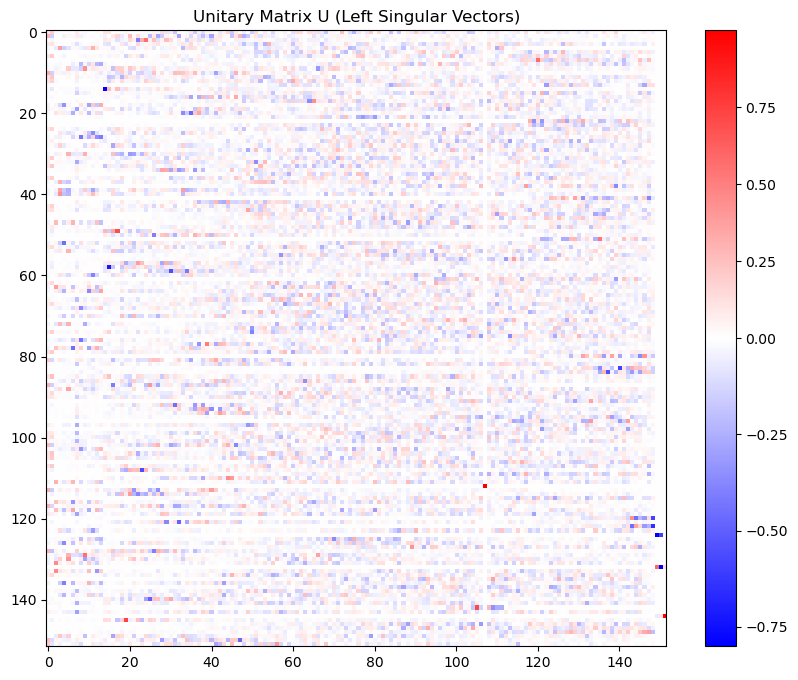

<Figure size 640x480 with 0 Axes>

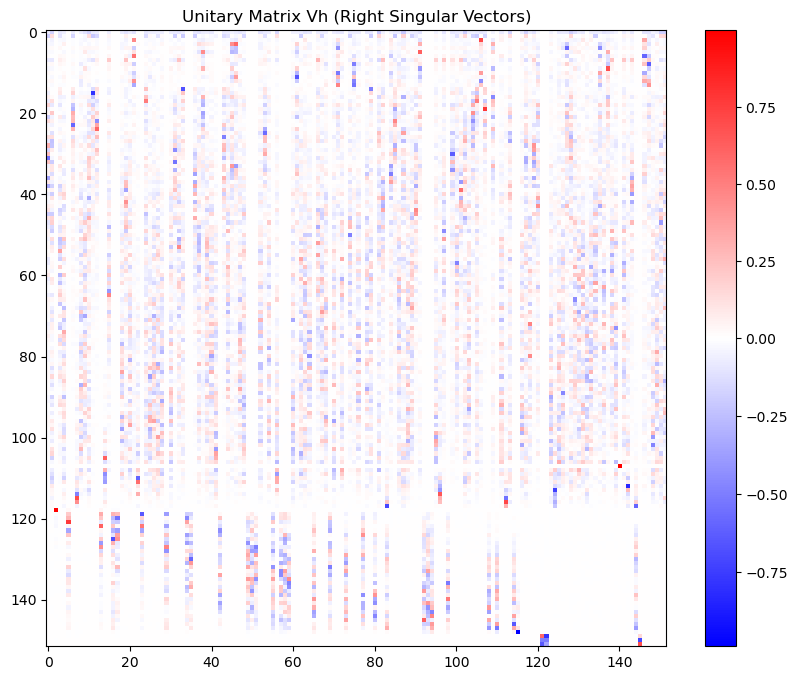

<Figure size 640x480 with 0 Axes>

In [45]:
# Plot the singular vectors
if plot:
    plt.figure(figsize=(10, 8))
    norm = colors.TwoSlopeNorm(vcenter=0)
    plt.imshow(U, cmap='bwr', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title('Unitary Matrix U (Left Singular Vectors)')
    if showplots:
        plt.show()
    else:
        plt.close()
    if saveplots:
        plt.savefig(plotpath + 'unitary_matrix_U.png')

    plt.figure(figsize=(10, 8))
    norm = colors.TwoSlopeNorm(vcenter=0)
    plt.imshow(Vh, cmap='bwr', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title('Unitary Matrix Vh (Right Singular Vectors)')
    if showplots:
        plt.show()
    else:
        plt.close()
    if saveplots:
        plt.savefig(plotpath + 'unitary_matrix_Vh.png')

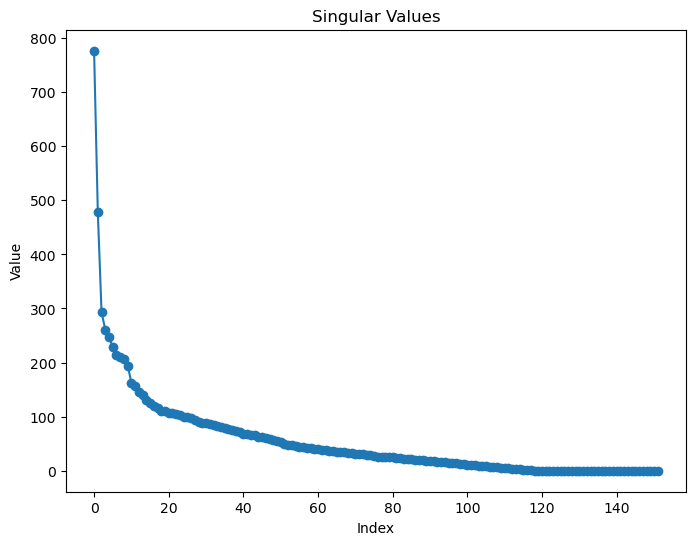

<Figure size 640x480 with 0 Axes>

In [46]:
# Plot the singular values
if plot:
    plt.figure(figsize=(8, 6))
    plt.plot(S, marker='o')
    plt.title('Singular Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    if showplots:
        plt.show()
    else:
        plt.close()
    if saveplots:
        plt.savefig(plotpath + 'singular_values.png')

### Eigendecomposition

In [24]:
# Compute the eigendecomposition
eigenvalues, eigenvectors = np.linalg.eig(connectivity_matrix)

# Print the results
print("Eigenvalues:")
print(eigenvalues)

print("\nEigenvectors:")
print(eigenvectors)

Eigenvalues:
[ 0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
  0.00000000e+00 +0.j          0.00000000e+00 +0.j
 -5.35194547e+02 +0.j         -4.75526236e+02 +0.j
 -1.98412510e+02 +0.j         -8.37316368e+01 +0.j
  8.69541152e+01 +0.j          7.72725755e+01 +0.j
  7.57463250e+01 +

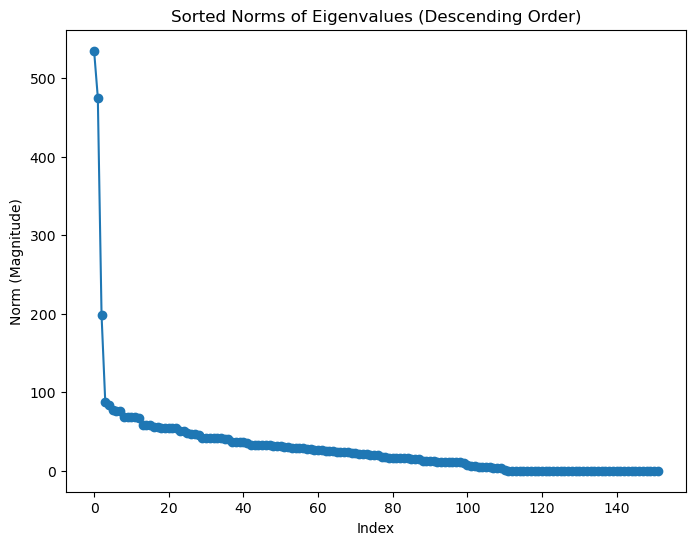

<Figure size 640x480 with 0 Axes>

In [30]:
# Calculate the norm (magnitude) of the eigenvalues
eigenvalue_norms = np.abs(eigenvalues)

# Sort the norms in descending order
sorted_norms_desc = np.sort(eigenvalue_norms)[::-1]

# Plot the sorted norms
if plot:
    plt.figure(figsize=(8, 6))
    plt.plot(sorted_norms_desc, marker='o')
    plt.title('Sorted Norms of Eigenvalues (Descending Order)')
    plt.xlabel('Index')
    plt.ylabel('Norm (Magnitude)')
    if showplots:
        plt.show()
    else:
        plt.close()
    if saveplots:
        plt.savefig(plotpath + 'eigenvalue_norms_sorted_desc.png')


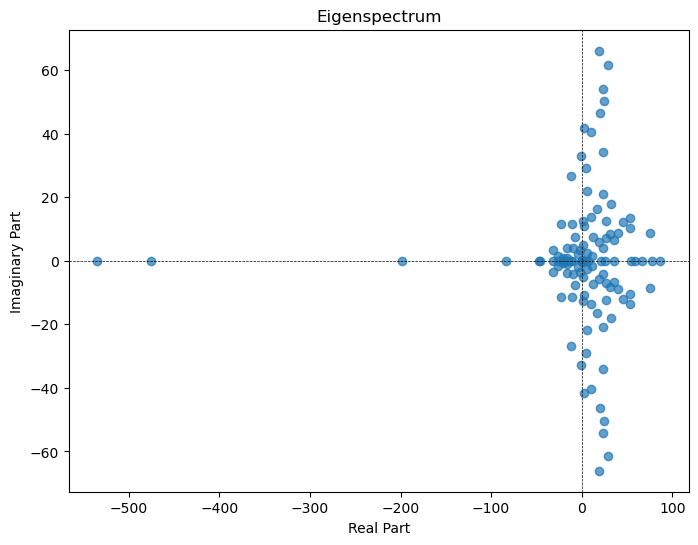

<Figure size 640x480 with 0 Axes>

In [29]:
# Plot the eigenspectrum (real vs imaginary parts of eigenvalues)
if plot:
    plt.figure(figsize=(8, 6))
    plt.scatter(eigenvalues.real, eigenvalues.imag, alpha=0.7)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.title('Eigenspectrum')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    if showplots:
        plt.show()
    else:
        plt.close()
    if saveplots:
        plt.savefig(plotpath + 'eigenspectrum.png')